In [16]:
import gym
import gym_anytrading
import pandas as pd
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
import yfinance as yf
import tf_slim as slim
import numpy as np
from matplotlib import pyplot as plt
from stable_baselines3 import DQN
import quantstats as qs
from stable_baselines3 import A2C
from stable_baselines.common.vec_env import DummyVecEnv

env = gym.make('forex-v0')
# env = gym.make('stocks-v0')

df = yf.download('BTC-USD', start='2020-06-01',
                   end='2022-12-12', interval='1h', back_adjust=True, auto_adjust=True, prepost=True)






def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data




[*********************100%***********************]  1 of 1 completed


In [17]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
                (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size):self._current_tick]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )


    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

In [18]:
import numpy as np




class ForexEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left'):
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size)

        self.trade_fee = 0.03  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward =0  # pip

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
                (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            step_reward += -1000

            if self._position == Positions.Short:
                step_reward += -price_diff * 10000
            elif self._position == Positions.Long:
                step_reward += price_diff * 10000

        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
                (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit

In [19]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data

In [20]:
env = MyForexEnv(df=df, window_size=12, frame_bound=(12, 12000))


print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())

env information:
> shape: (12, 4)
> df.shape: (15893, 5)
> prices.shape: (12000,)
> signal_features.shape: (12000, 4)
> max_possible_profit: 2044808588084.8506


In [21]:
model_train = DQN('MlpPolicy', env, verbose=1)
model_train.learn(total_timesteps=1000000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+04  |
|    ep_rew_mean      | 2.43e+06 |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 36885    |
|    time_elapsed     | 1        |
|    total_timesteps  | 47948    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+04  |
|    ep_rew_mean      | 1.06e+08 |
|    exploration_rate | 0.089    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 7841     |
|    time_elapsed     | 12       |
|    total_timesteps  | 95896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.65e+05 |
|    n_updates        | 11473    |
-------------------------------

In [23]:
env = MyForexEnv(df=df, window_size=12, frame_bound=(12000, len(df)))
obs = env.reset()
while True:
    #obs = obs[np.newaxis, ...]
    action, _states = model_train.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -95399562.5, 'total_profit': 1.0946872941709243, 'position': 1}


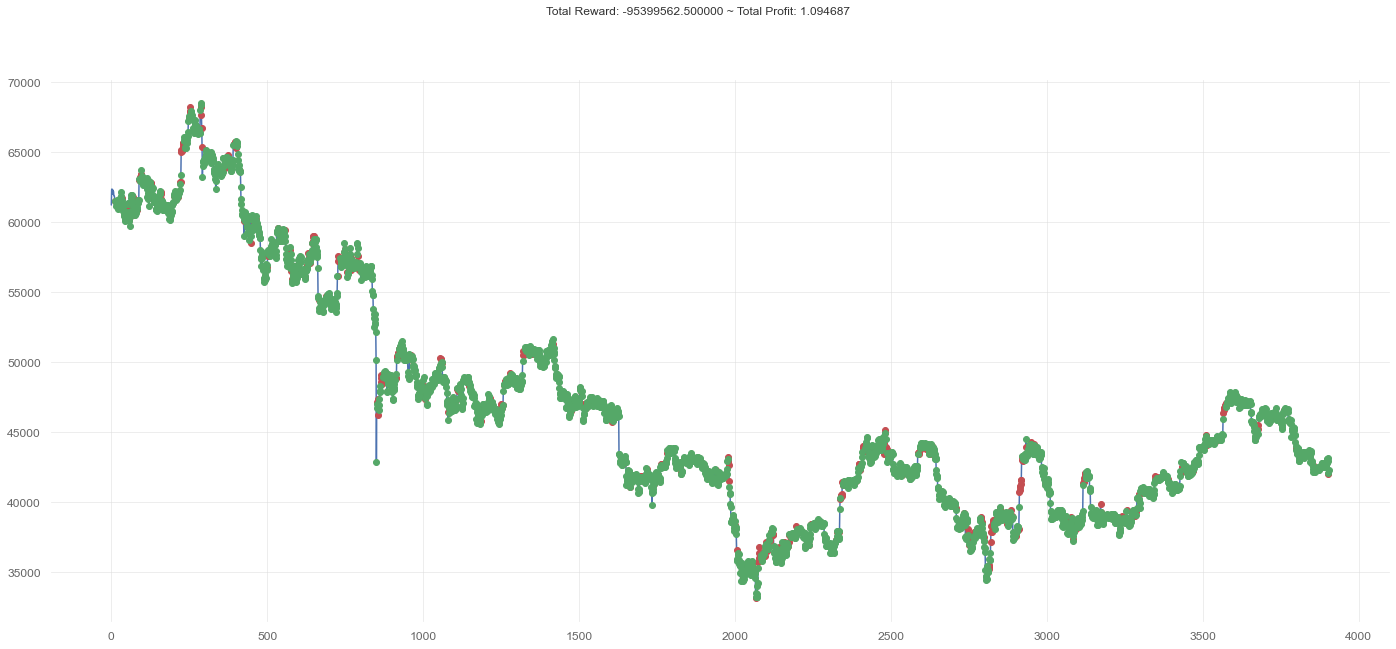

In [24]:

plt.figure(figsize=(24,10))
env.render_all()
plt.show()

In [27]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[12000+1:len(df)])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')

TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and datetime

In [26]:
env.history

{'total_reward': [1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  1709546.875,
  -1836609.375,
  -2180929.6875,
  -2180929.6875,
  -2180929.6875,
  -2180929.6875,
  -2180929.6875,
  -2180929.6875,
  -2180929.6875,
  -2180929.6875,
  3232679.6875,
  4650585.9375,
  4650585.9375,
  892281.25,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  1692492.1875,
  285164.0625,
  -3705757.8125,
  -3705757.8125,
  -3705757.8125,
  -3705757.8125,
  -16187890.625,
  -15987171.875,
  -15987171.875,
  -15987171.875,
  -15987171.875,
  -15987171.875,
  -15987171.875,
  -15987171.875,
  -15987171.875,
  -15987171.875,
  993156.25,
  993156.25,
  993156.25,
  4331687.5,
  4331687.5,
  4331687.5,
  4331687.5,
  -5425484.375,
  -718

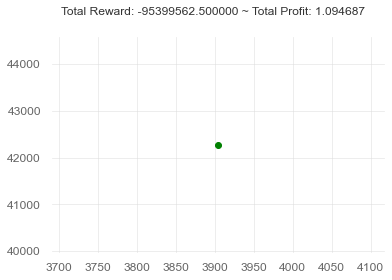

In [31]:
env.render()